# BitMEX Wallets in/outflow
Date: 5/29/20  
Author: Evan Azevedo  
Organization: Amberdata  

## Description
Exploring the question: observing the in/outflows from BitMEX wallets, is there some impact on price? 

## Research Question
Does the inflow of money into BitMEX wallets have any correlation with the price?

### Key information
* All wallet addresses start with BMEX (I think those are motor bikes?)
* BitMEX have a single daily withdraw. So these wallets can take a lot of deposits, but limited withdraw - similar to a High Yield Savings acct.

In [31]:
# import the packages
import os
import requests
import json
import datetime
from concurrent.futures import ThreadPoolExecutor, wait

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import tqdm

N = 60 # Number of days to consider
A = 2500 # number of addresses
P = 20 # the number of addresses to analyze in parallel

In [17]:
# Important Utility functions

def get_key():
    "Get the API key from an .env file"
    if ".env" not in os.listdir("../"):
        print("Configuring API Key...")
        key = input("Amberdata API Key: ")
        with open(".env", "w") as f:
            f.write(f"AMBERDATA_API_KEY={key}\n")
    load_dotenv(verbose=True)
    return {
        "AMBERDATA_API_KEY": os.getenv("AMBERDATA_API_KEY")
    }

def get_response(url, headers=None, queryString=None):
    "Get the REST response from the specified URL"
    if not headers:
        headers = {'x-api-key': api_key}
    if queryString:
        response = requests.request("GET", url, headers=headers, params=queryString)
    else:
        response = requests.request("GET", url, headers=headers)
    response = json.loads(response.text)
    if response["title"] == "OK":
        return response["payload"]
    else:
        raise Exception
        
def inflow_outflow(data: dict):
    "Returns the inflow and outflow of the payload"
    # get the column names
    columns = data["metadata"]["columns"]
    # load the data, dropping timestampNano
    ad_hist = pd.DataFrame(data["data"], columns=columns).drop("timestampNanoseconds", axis=1)
    # change dtype of appropriate columns to Int
    ad_hist[["blockNumber", "timestamp", "value"]] = ad_hist[["blockNumber", "timestamp", "value"]].apply(pd.to_numeric)
    # sort by blockNum desc
    ad_hist = ad_hist.sort_values("timestamp").reset_index(drop=True)
    # calculate inflow and outflow
    ad_hist["diff"] = ad_hist["value"].diff()
    ad_hist["inflow"] = np.where(ad_hist["diff"] > 0, ad_hist["diff"], 0)
    ad_hist["outflow"] = np.where(ad_hist["diff"] < 0, abs(ad_hist["diff"]), 0)
    # return the result
    return ad_hist

def reindex(data, index):
    """ Returns the DataFrame calculated w/ inflow & outflow
    :type data: DataFrame
    :type index: List[int]
    :rtype: DataFrame
    """
    d = np.digitize(data.timestamp.values, index)
    g = data[["inflow", "outflow"]].groupby(d).sum()
    g = g.reindex(range(N), fill_value=0)
    g.index = index
    return g

def daily_inflow_outflow(address, headers, querystring):
    url = "https://web3api.io/api/v2/addresses/" + address + "/account-balances/historical"
    try:
        payload = get_response(url=url, headers=headers, queryString=querystring)
    except Exception:
        return None
    if len(payload["data"]) > 1:   # if there is activity in the period
        # calculate inflow / outflow
        data = inflow_outflow(payload)
        # get in the format to merge with master inflow/outflow data
        g = reindex(data, index)
        return g
        
# get our API Key
api_key = get_key()["AMBERDATA_API_KEY"]

In [18]:
# Read the data
df = pd.read_excel("../input/Cluster_addresses_of_Bitmex.xlsx", header=12, skipfooter=3)

## Calculate Inflow Outflow
This part can be improved in several ways.
* Adding all BitMEX addresses. Currently, we are only using addresses that begin with `3BMEX`, but there is also another suffix for BitMEX Bitcoin wallets, `3BitMEX`. The barrier here is writing a query on the `accounts` table, which is incredibly large. Working with Joanes on this.
* **Minor** - Continuously spin up threads as they finish, rather than waiting for all threads to finish in a batch. Can work with Peng on this. Adding concurrency sped up calculation 5x, from 40 hrs -> 8 hrs.
* **Major** - This is not a sufficient way to calculate Inflow / Outflow. We are effectively counting all transactions between wallets twice. I will illustrate what I mean below.  

**Here is what we are calculating:**  
Suppose we have two BitMEX bitcoin wallets, A and B. Both wallets have a balance of 1000 USD and 1 BTC. Wallet A agrees to buy 0.1 BTC from wallet B for 1000 USD. We calculate wallet A to have an outflow of 1000 USD, and wallet B to have an inflow of 1000 USD. This is how we were able to see crazy volumes of $10^{11}$ in inflow / outflow.

**Here is what we want to calculate:**  
Suppose we have one wallet, A. Wallet A has no balance. The user loads wallet A with 1000 USD to begin trading on BitMEX. Now the inflow = 1000 USD. The user makes some trades, sells his positions, now has an account balance of 1100 USD, and would like to realize his gains. User now withdraws 1100 USD from his account. This is an outflow of 1100 USD.

In [32]:
# Set the start and endtime for analysis
endTime = datetime.datetime.now()
startTime = endTime - datetime.timedelta(N)

endTime = str(int(endTime.timestamp()))
startTime = str(int(startTime.timestamp()))

querystring = {"startDate": startTime,
               "endDate": endTime}

headers = {
    'x-amberdata-blockchain-id': "bitcoin-mainnet",
    'x-api-key': api_key
}

# create an index of daily values based on the time format
index = [10**3*(int(startTime) + i*24*60**2) for i in range(N)]
# create the output dataframe
columns = ["inflow", "outflow"]
gross_daily = pd.DataFrame(index=index, columns=columns).fillna(0)

# check if we are running the full calculation
if A:
    addresses = df.iloc[:A].Address.values
else:
    addresses = df.Address.values

# calculate inflow/outflow from the addresses in parallel
for i in tqdm.trange(len(addresses) // P):
    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = [executor.submit(daily_inflow_outflow, addresses[P*i+j], headers, querystring) for j in range(P) if i+j < len(addresses)]
        wait(futures)
        for future in futures:
            if future.result() is not None:
                res = future.result()
                gross_daily += res
        
# calculate the net flows
gross_daily["net"] = gross_daily["inflow"] - gross_daily["outflow"]
# set index to datetime
gross_daily.index = [datetime.datetime.fromtimestamp(ts//1000).date() for ts in index]
# Rescale value by 10^8
gross_daily = gross_daily/10**8

print(gross_daily.head())

100%|██████████| 125/125 [04:13<00:00,  2.03s/it]

               inflow     outflow         net
2020-04-04   0.000000    0.000000    0.000000
2020-04-05   0.026000    0.000000    0.026000
2020-04-06   0.218199   18.965055  -18.746856
2020-04-07   0.101447  304.262440 -304.160993
2020-04-08  12.233146   52.071224  -39.838078


## Get the Bitcoin OHLCV

In [35]:
pair = "xbtusd_bitmex"

url = "https://web3api.io/api/v2/market/ohlcv/"+pair+"/historical"

querystring = {"exchange":"bitmex","startDate":startTime,"endDate":endTime,"timeInterval":"days"}

headers = {'x-api-key': api_key}

payload = get_response(url, headers=headers, queryString=querystring)

ohlcv = pd.DataFrame(payload["data"]["bitmex"], columns=payload["metadata"]["columns"]).iloc[1:]
ohlcv = ohlcv.drop(["open", "high", "low", "timestamp"], axis=1)
ohlcv.index = [datetime.datetime.fromtimestamp(ts//1000).date() for ts in index]

## Plot the Results

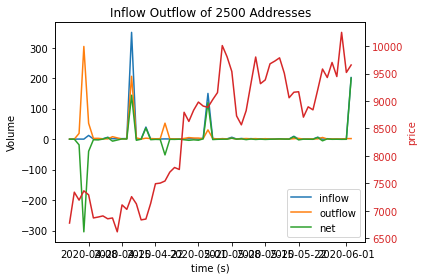

In [36]:
fig, ax1 = plt.subplots()

ax1.set_title(f"Inflow Outflow of {A} Addresses")
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Volume')
ax1.plot(gross_daily)
ax1.tick_params(axis='y')
ax1.legend(["inflow", "outflow", "net"], loc=4)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel("price", color=color)  # we already handled the x-label with ax1
ax2.plot(ohlcv.close, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

# Analysis
Looking for a relationship between Inflow/Outflow and Price.
### Ideas
* Correlation
* Dynamic Time Warping
* [Cointegration](https://www.quora.com/What-is-cointegration-of-time-series-data-in-statistics-How-do-you-identify-pairs-of-stocks-for-trading-Is-it-based-on-simple-correlation-analysis-or-is-there-a-more-rigorous-method?share=1) - Engle-Granger Test

In [160]:
from scipy.stats.stats import pearsonr

print(pearsonr(ohlcv.close, gross_daily.net))

(-0.14694072792975102, 0.4384287447765489)
